# Spaceborne demo notebook
This notebook shows how to use `Spaceborne` to compute photometric covariance matrices, and then how to load and unpack them for subsequent analyses. Please keep in mind that more in-depth information about the different settings and the code in general can be found, respectively, in the [example configuration file](https://github.com/davidesciotti/Spaceborne/blob/main/config.yaml) and in the official [documentation](https://spaceborne.readthedocs.io/en/latest/?badge=latest)

## Inputs
To begin with, let's import the necessary libraries, define the paths to the input files, and show the format that the code expects for the input data.
In general, besides the settings defined in the configuration file, the user needs to provide as external inputs:

* **The source and/or lens redshift distributions**. These are required to compute radial kernels and $C_\ell$. Even when using input $C_\ell$, the redshift distributions are still needed to project the SSC and cNG trispectra; in short, they are mandatory in the following cases:
    * when using internally-generated $C_\ell$ (aka, `cfg['C_ell']['use_input_cls'] = False`)
    * if the SSC and/or cNG covariance contributions are required (i.e., `cfg['covariance']['SSC'] = True` and/or `cfg['covariance']['cNG'] = True`) 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import yaml
from spaceborne import sb_lib as sl

In [ ]:
# generate smail distributions
def smail_zdist(z, z0=0.9):
    """Generate a Smail et al. (1994) redshift distribution.

    Parameters
    ----------
    z : array_like
        Redshift values where the distribution is evaluated.
    alpha : float, optional
        Parameter alpha of the Smail distribution. Default is 2.0.
    beta : float, optional
        Parameter beta of the Smail distribution. Default is 1.5.
    z0 : float, optional
        Parameter z0 of the Smail distribution. Default is 0.5.

    Returns
    -------
    n_z : array_like
        The redshift distribution evaluated at the input redshift values.
    """

    n_z =  (z / z0) ** 2 * np.exp(-(z / z0) ** 1.5)
    return n_z

def normalize_nz(n_z, z):
    """Normalize a redshift distribution.

    Parameters
    ----------
    n_z : array_like
        The redshift distribution to be normalized.
    z : array_like
        Redshift values corresponding to the distribution.

    Returns
    -------
    n_z_normalized : array_like
        The normalized redshift distribution.
    """
    integral = np.trapezoid(n_z, z)
    n_z_normalized = n_z / integral
    return n_z_normalized

Text(0, 0.5, '$n_i(z)$')

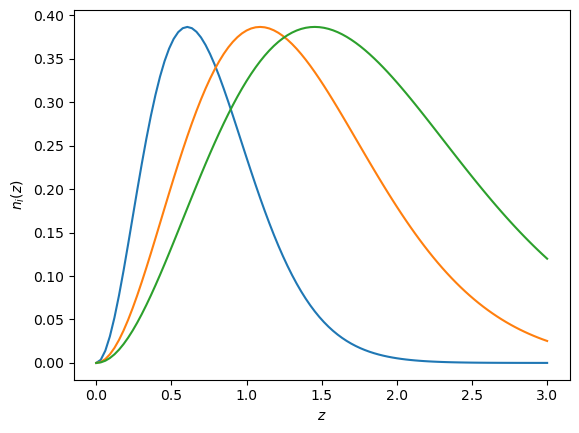

In [12]:
# plot smail
z = np.linspace(0, 3, 100)
n_z_1 = smail_zdist(z, z0=0.5)
n_z_2 = smail_zdist(z, z0=0.9)
n_z_3 = smail_zdist(z, z0=1.2)
plt.plot(z, n_z_1)
plt.plot(z, n_z_2)
plt.plot(z, n_z_3)
plt.xlabel('$z$')
plt.ylabel('$n_i(z)$')


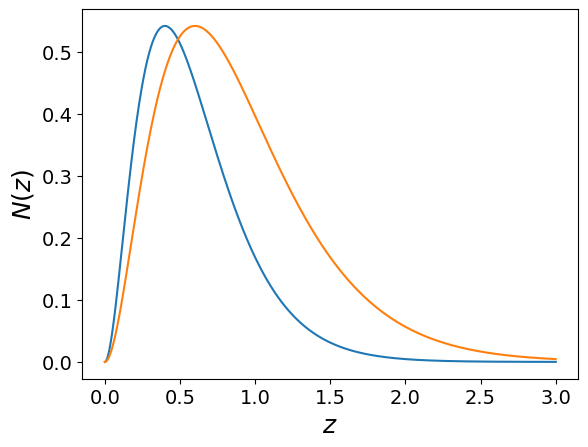

In [9]:
nofz = []
bias = []

z = np.linspace(0., 3., 512)
z0 = 0.2
pz = (z / z0)**2. * np.exp(-z/z0) # Redshift distribution, p(z)
dNdz = pz # Number density distribution
b = 1.5*np.ones(512) #Galaxy bias (constant with scale and z)
nofz.append(dNdz)
bias.append(b)

z = np.linspace(0., 3., 512)
z0 = 0.3
pz = (z / z0)**2. * np.exp(-(z)/z0) # Redshift distribution, p(z)
dNdz = pz # Number density distribution
b = 2*np.ones(512) #Galaxy bias (constant with scale and z)
nofz.append(dNdz)
bias.append(b)


plt.xlabel('$z$',fontsize=18)
plt.ylabel('$N(z)$',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(z, nofz[0])
plt.plot(z, nofz[1])
plt.show()